[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/accdavlo/calcolo-scientifico/blob/main/codes/FEM_with_FEniCS.ipynb)

# Finite element with FEniCS
In this notebook we will use the FEniCS library to solve the Poisson problem in 2D con complex geometries.

[FEniCS project](https://fenicsproject.org/) is a Finite element library which allows to use a very high level language to define complex problems, helping mathematicians getting quickly done with their ideas.
Lately the developers of FEniCS have moved to the new version FEniCSx, but we will use the old one, where some functions are of simpler use.

So, be careful when you install it on your laptop: choose the right version! FEniCS 2018 has also compatibility with `mshr` a library that allows to generate meshes in python. We will stick to this combo.

In Google Colab, Francesco Ballarin has developed a library [FEM on Colab](https://fem-on-colab.github.io/) that allows to quickly install the packages on Google remote servers. We will use it in the next cell.
Still, this is highly discouraged for local computers. It might work, but you have less control on your installation!



In [2]:
import fenics

ModuleNotFoundError: No module named 'fenics'

In [ ]:
# Setting some plotting styles
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 9)

In [ ]:
# Importing some libraries
from dolfin import * # This is the core of FEniCS and it contains all the FEM functions we will need
from ufl_legacy.geometry import * # This helps in designing geometries
from dolfin.cpp.mesh import *     # This handles meshes
from mshr import *                # This generates meshes

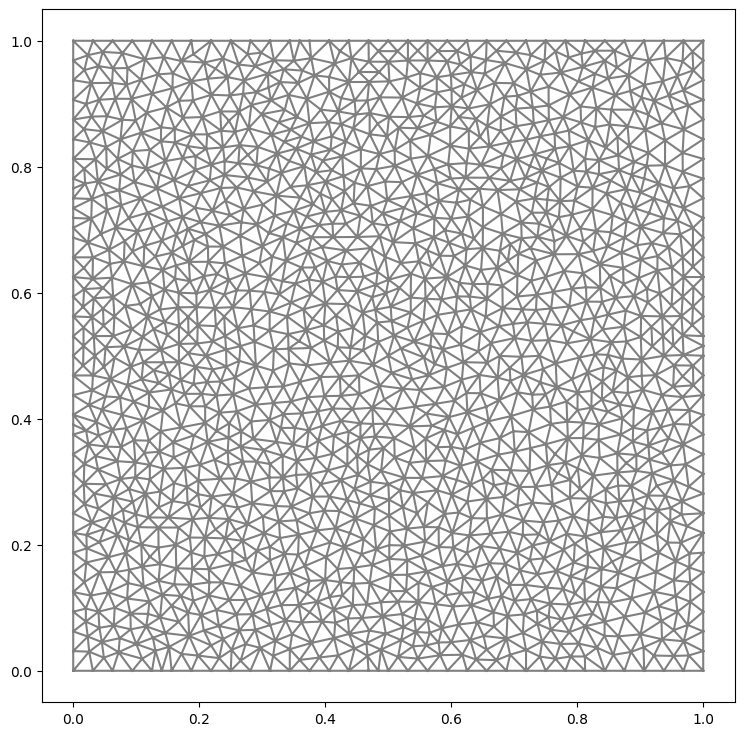

In [ ]:
# First step: generate a mesh

# Define a domain
domain = Rectangle(Point(0, 0), Point(1, 1))

# Define a mesh with N points on an edge
mesh = generate_mesh(domain, 32)

# Plot the mesh
plot(mesh)

Now the real Finite element experience.

Say we want to solve Poisson on the square with Dirichlet homogenous boundary conditions on all sides except the top one where we use Dirichlet BC
$$
\int_\Omega \nabla u \cdot \nabla v \mathrm{d}x = \int_\Omega fv \mathrm{d}x
$$
and we set $f\equiv 1$.

In [ ]:
# First of all we define the type of Finite element we want to use, this is the equivalent of the reference element we have used in 1D
# 1 is the degree of the used polynomials, one can also try with something larger
V_element = FiniteElement('Lagrange', triangle, 1)

# Then we define the functional space, which depends on the mesh and on the reference element V_element
V = FunctionSpace(mesh, V_element)

# Now we define two types of functions: trial functions and test functions.
# Trial functions are the one that will be used in place of the unknown u of the linear system that sooner or later we will need to generate. They correspond to the columns of the linear system
# Test functions are the ones against which the problem is tested, they will define the rows of the system.
# Functions are the objects that will contain the solution of the problem, they are the ones that will be used to plot the solution
u = TrialFunction(V)
v = TestFunction(V)
z = Function(V)



What can we do with a function? We can assign some values from an analytical expression and plot it!

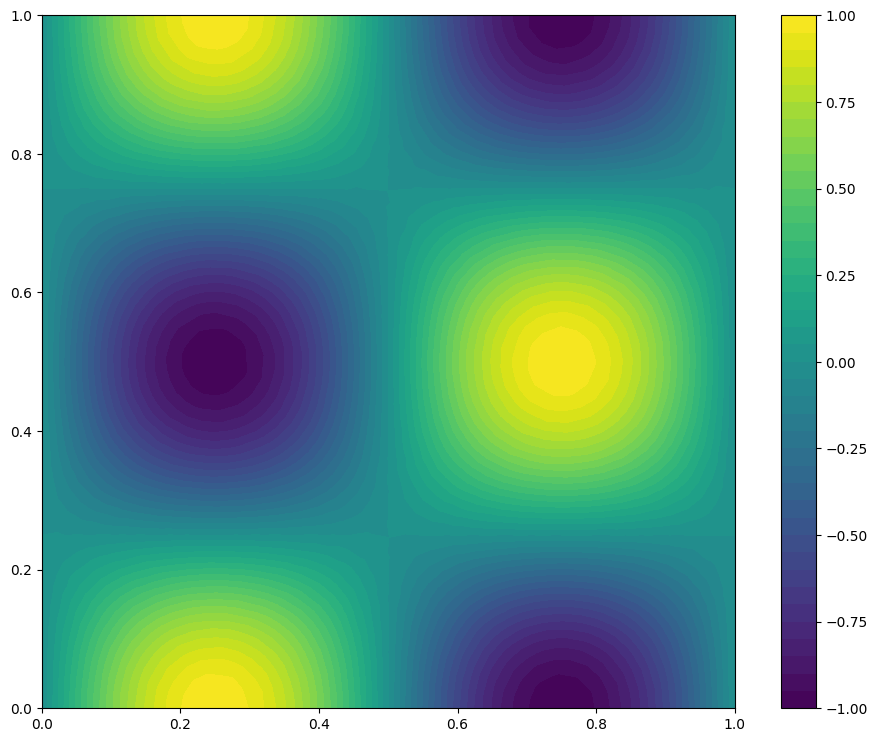

In [ ]:
z = Function(V)
z.assign(Expression('sin(2*pi*x[0])*cos(2*pi*x[1])', degree=2)) # Degree is the degree of the polynomial interpolation inside each element
# z.assign(Constant(1.))
pp=plot(z)
plt.colorbar(pp)

Define some details of the problem: BC and rhs function

In [ ]:
# We define the boundary conditions, we need the functional space, the value and where we want to put them to zero (the three sides of interest)
zero_BC = DirichletBC(V, 0.,
                      "on_boundary && \
                      (x[0]<DOLFIN_EPS | x[0]>1.0-DOLFIN_EPS |\
                      x[1]<DOLFIN_EPS)")

# For homogeneous Neumann bcs we do not need to do anything

# Constant function that can be used by FEniCS to be integrated
f = Constant(1.) # This is the right hand side of the equation (also Expression could be used here)

Here the weak problem in its majesty: we define the left-hand-side of the problem as the scalar product between the gradients of the test and trial function

`*dx` means that we are integrating over the whole domain

Similarly for the rhs, we compute the integral of `f*v*dx`

In [ ]:

lhs = inner(grad(u),grad(v))*dx
rhs = f*v*dx

print(type(lhs))

<class 'ufl_legacy.form.Form'>


These are not yet matrices, but ufl forms, FEniCS knows how to deal with these objects to automatically assemble the matrices/vectors in a sparse way within a dolfin type that is derived from the `PETSc` library (under the hood it's using some C++ and Fortran libraries)

In [ ]:
LHS = assemble(lhs)
RHS = assemble(rhs)

print(type(LHS))
print(type(RHS))

<class 'dolfin.cpp.la.Matrix'>
<class 'dolfin.cpp.la.Vector'>


Time to apply the boundary conditions!
As for the 1D case, we change the Dirichlet DoFs equations by directly modifying the lhs matrix and the rhs vector. This creates fake equations for those dofs that assing the appropriate Dirichlet boundaries

In [ ]:
zero_BC.apply(LHS)
zero_BC.apply(RHS)

Finally, we can solve the problem. By default the linear solver of FEniCS is set to an incomplete LU decomposition, but one can manually change it.


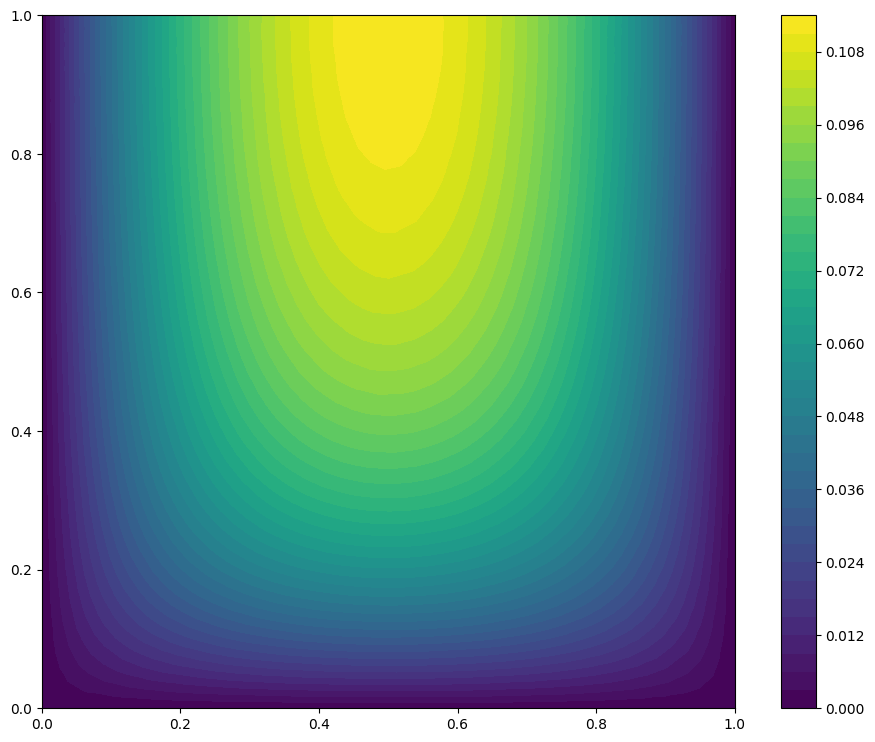

In [ ]:
# Third type of functions after TrialFunction, TestFunction

# Function(V) is a simple FEM function: it stores the coefficients of the basis functions and it reference to all the functional space structures for complicated steps
u_sol = Function(V)

# We solve the linear system LHS*u=RHS -> syntax follows this order
# Careful that here the solution of a linear system is not a Function, but a vector, so we have to assign it to the vector of u_sol
solve(LHS, u_sol.vector(), RHS)

# Finally we plot our solution
pp=plot(u_sol)
plt.colorbar(pp)

### Exercise convergence analysis:
1. Try to solve the problem for a known an exact solution (you can change the problem e.g. $u = \sin(2\pi x)+\cos(2\pi y)$ with $-\Delta u=4\pi^2\sin(2\pi x)+\cos(2\pi y)$)
1. Compute the error with respect to the exact solution ($L^2$ relative error can be computed as `np.sqrt(assemble(inner(u-u_e,u-u_e)*dx)/np.sqrt(inner(u_e,u_e)*dx))`)
1. See what happens when the mesh changes
1. Change the degree

Hints:
1. To deal with complex expressions for the right hand side or other terms in the weak formulations use the function `Expression`, e.g.
```
f = Expression('exp(-10.0*(pow(x[0]-0.75,2) + pow(x[1] - 0.75,2)))',degree = 2)
```
1. To integrate on boundaries instead on the whole domain, use `* ds` to make FEniCS know you want to integrate on the boundaries (in comparison to `* dx` for the integrals on the whole domain)

 We can try to solve the problem by simply changing the $z$ function in the past problem.

In [ ]:
mesh = generate_mesh(domain, 60)

In [ ]:
# First of all we define the type of Finite element we want to use, this is the equivalent of the reference element we have used in 1D
# 1 is the degree of the used polynomials, one can also try with something larger
V_element = FiniteElement('Lagrange', triangle, 3)

# Then we define the functional space, which depends on the mesh and on the reference element V_element
V = FunctionSpace(mesh, V_element)

# Now we define two types of functions: trial functions and test functions.
# Trial functions are the one that will be used in place of the unknown u of the linear system that sooner or later we will need to generate. They correspond to the columns of the linear system
# Test functions are the ones against which the problem is tested, they will define the rows of the system.
# Functions are the objects that will contain the solution of the problem, they are the ones that will be used to plot the solution
u = TrialFunction(V)
v = TestFunction(V)
z = Function(V)



Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_780eb9ddb42feb9c6996c1225460f0d8c3f18bb9

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00219083 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.313293 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:----------------------------

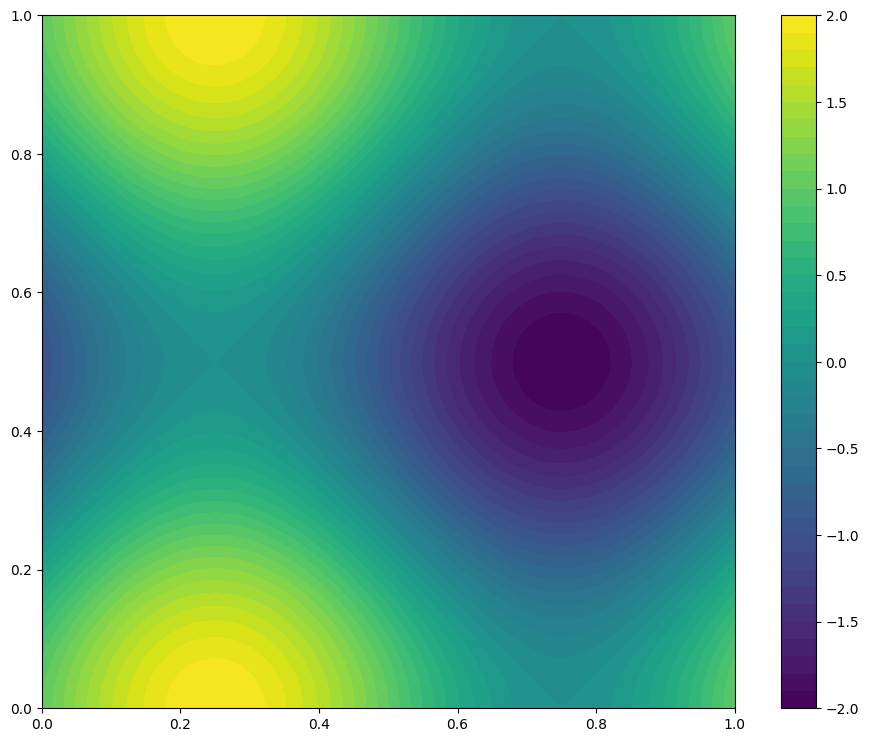

In [ ]:
z = Function(V)
z.assign(Expression('sin(2*pi*x[0]) + cos(2*pi*x[1])', degree=2)) # Degree is the degree of the polynomial interpolation inside each element
# z.assign(Constant(1.))
pp=plot(z)
plt.colorbar(pp)

Define some details of the problem: BC and rhs function

In [ ]:
## Boundaries
left = 'near(x[0],0)'
right = 'near(x[0],1)'
bottom = 'near(x[1],0)'
top = 'near(x[1],1)'

# We define the boundary conditions, we need the functional space, the value and where we want to put them to zero (the three sides of interest)
bc_left = DirichletBC(V, Expression('cos(2*pi*x[1])', degree=2), left)
bc_right = DirichletBC(V, Expression('cos(2*pi*x[1])', degree=2), right)
bc_bottom = DirichletBC(V, Expression('1+sin(2*pi*x[0])', degree=2), bottom)
bc_top = DirichletBC(V, Expression('1+sin(2*pi*x[0])', degree=2), top)

bcs = [bc_left, bc_right, bc_bottom, bc_top]

# For homogeneous Neumann bcs we do not need to do anything

# Constant function that can be used by FEniCS to be integrated
f = Expression('4*pi*pi*(sin(2*pi*x[0]) + cos(2*pi*x[1]))', degree=2) # This is the right hand side of the equation (also Expression could be used here)

In [ ]:
lhs = inner(grad(u),grad(v))*dx
rhs = f*v*dx

print(type(lhs))

<class 'ufl_legacy.form.Form'>


In [ ]:
LHS = assemble(lhs)
RHS = assemble(rhs)

print(type(LHS))
print(type(RHS))

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_630d8dbea38f9ddb787dae812701c19d44755a30

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG3(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG3(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0194399 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_acc1e1d5f7a2807718f081eff7f7856ce59cdeab

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00232315 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00984192 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representat

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_982e79a9f4acc790c809f27095254e9638e78264

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_640]'
  Unique elements:           'CG3(?,?), CG2(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG3(?,?), CG2(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 5
INFO:FFC:  quadrature_degree: 5
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0177884 seconds.

INFO:FFC:Comp

<class 'dolfin.cpp.la.Matrix'>
<class 'dolfin.cpp.la.Vector'>


In [ ]:
for bc in bcs:
  bc.apply(LHS)
  bc.apply(RHS)

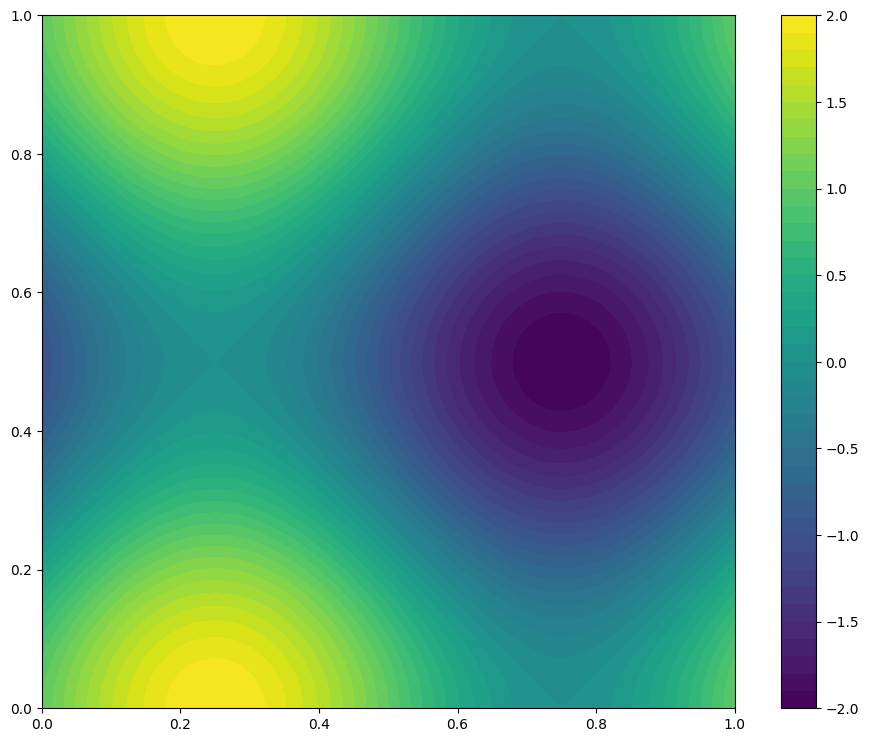

In [ ]:
# Third type of functions after TrialFunction, TestFunction

# Function(V) is a simple FEM function: it stores the coefficients of the basis functions and it reference to all the functional space structures for complicated steps
u_sol = Function(V)

# We solve the linear system LHS*u=RHS -> syntax follows this order
# Careful that here the solution of a linear system is not a Function, but a vector, so we have to assign it to the vector of u_sol
solve(LHS, u_sol.vector(), RHS)

# Finally we plot our solution
pp=plot(u_sol)
plt.colorbar(pp)

In [ ]:
import numpy as np

u_e = Function(V)
u_e.assign(Expression('sin(2*pi*x[0]) + cos(2*pi*x[1])', degree=2))

err = np.sqrt(assemble(inner(u_sol-u_e,u_sol-u_e)*dx))/np.sqrt(assemble(inner(u_e,u_e)*dx))
err

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_b6525fc431f38dcddbe268e914b31a1aadd83963

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    2
  Coefficients:              '[f_651, f_660]'
  Unique elements:           'CG3(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG3(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 6
INFO:FFC:  quadrature_degree: 6
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0152545 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_0d0017e2b50d76283554e9d00f8fac6ea412b0e9

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    1
  Coefficients:              '[f_660]'
  Unique elements:           'CG3(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG3(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 6
INFO:FFC:  quadrature_degree: 6
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0153518 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------------------

np.float64(4.734679181061911e-08)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_1bc009496cb05d0b0bb5527a866f6d5e9c111440

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    2
  Coefficients:              '[f_651, f_660]'
  Unique elements:           'CG1(?,?), CG3(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), CG3(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0158725 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:--

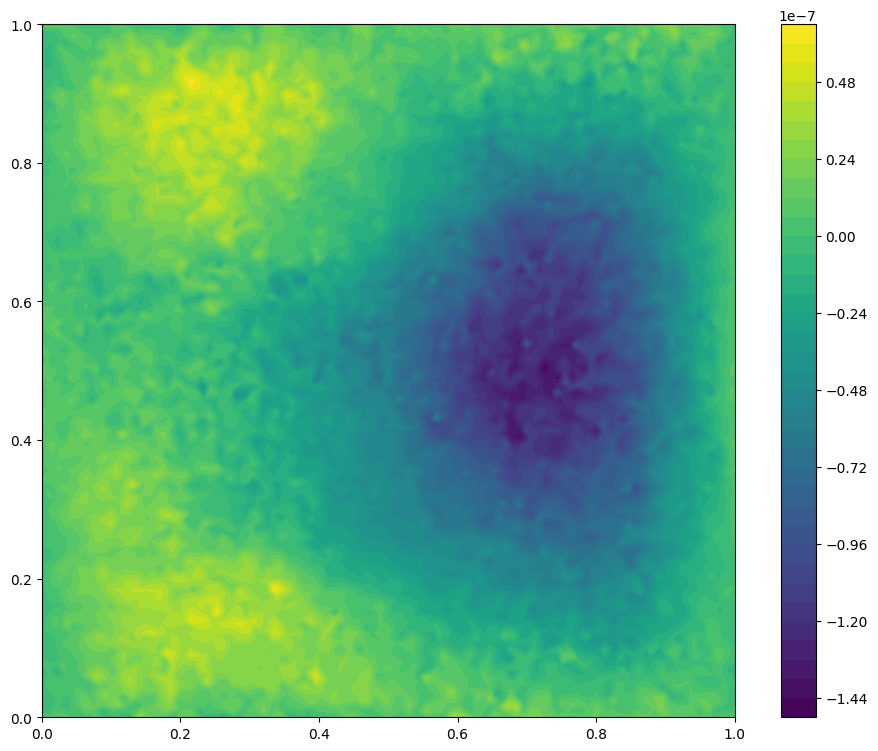

In [ ]:
# Function difference plot
pp=plot(u_e-u_sol)
plt.colorbar(pp)

## Complex geometries
In the next test, we use as a domain a 2D representation of a long channel with a cylinder in it. This is composed of a rectangle minus a circle

10903
5636


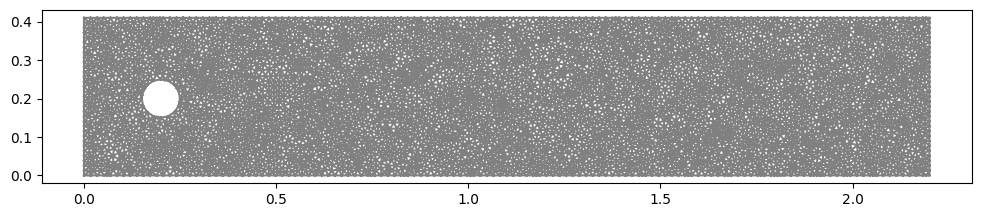

In [ ]:
# Defining the channel
channel  = Rectangle(Point(0.,0.),Point(2.2,0.41))
# Defining the cylinder
cylinder_diam = 0.1
cylinder = Circle(Point(0.2,0.2), cylinder_diam/2.)

# Defining the domain
domain = channel-cylinder

# Denerate the mesh
mesh = generate_mesh(domain, 100)
plot(mesh)

print(mesh.num_cells())
print(mesh.num_vertices())

In [ ]:
V_element = FiniteElement('Lagrange', triangle, 1)
V = FunctionSpace(mesh, V_element)
u = TrialFunction(V)
u_sol = Function(V)
v = TestFunction(V)

f = Constant(0.)



### More complex BC!
For each of the boundaries I define a different Dirichlet BC with constant coefficients:
* 0 on the left
* 1 on the right
* 3 on the bottom
* -2 on the top
* -1 on the cylinder  

In [ ]:
## Boundaries
DirichletBC(V, 0.,
                      "on_boundary && \
                      (x[0]<DOLFIN_EPS | x[0]>1.0-DOLFIN_EPS |\
                      x[1]<DOLFIN_EPS)")
left = 'near(x[0],0)'
right = 'near(x[0],2.2)'
bottom = 'near(x[1],0)'
top = 'near(x[1],0.41)'
cylinder_surf = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3'
# if it sees any DOF which is close to the boundary, it is inside the cylinder

bc_left = DirichletBC(V, 0., left)
bc_right = DirichletBC(V, 1., right)
bc_bottom = DirichletBC(V, 3., bottom)
bc_top = DirichletBC(V, -2., top)
bc_cylinder = DirichletBC(V, -1., cylinder_surf)

bcs = [bc_left, bc_right, bc_bottom, bc_top, bc_cylinder]

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_8a1899c41ab469ea970876b2052caff1f76ebd21

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_66]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0188258 seconds.

INFO:FFC:Compiler stage 2:

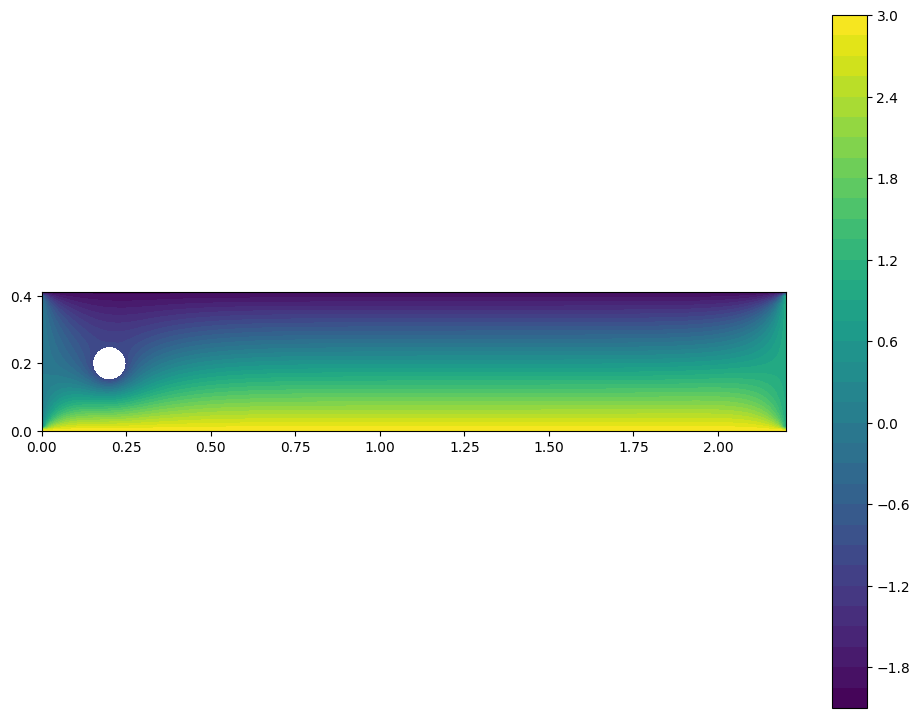

In [ ]:
# Write the weak form
lhs = inner(grad(u),grad(v))*dx
rhs = inner(f,v)*dx

# Assemble matrix
LHS = assemble(lhs)
RHS = assemble(rhs)

# Apply BC for all BCs in the list
for bc in bcs:
    bc.apply(LHS)
    bc.apply(RHS)

# Solve the liner problem
solve(LHS, u_sol.vector(), RHS)

# Plot the solution and add a colorbar
pp=plot(u_sol)
plt.colorbar(pp)

## Exercises
1. More complex domains: add two squares with some overlaps and remove a couple of circles
1. Different problems! Add a reaction term $\sigma \int uv \textrm{d}x$, or add a fourth derivative (using high order FEMs)

Hint:
1. When dealing with very complex boundaries, you might need to use longer functions. The following example might help.
```
def boundary(x, on_boundary):
    d0 = sqrt((x[0]-0.5)**2 + (x[1]-0.5)**2)
    d1 = sqrt((x[0]-1.0)**2 + (x[1]-1.0)**2)
    return on_boundary and (d0 < 0.3 or d1 < 0.3)
bc = DirichletBC(V, 0 , boundary)
```

18215
9389


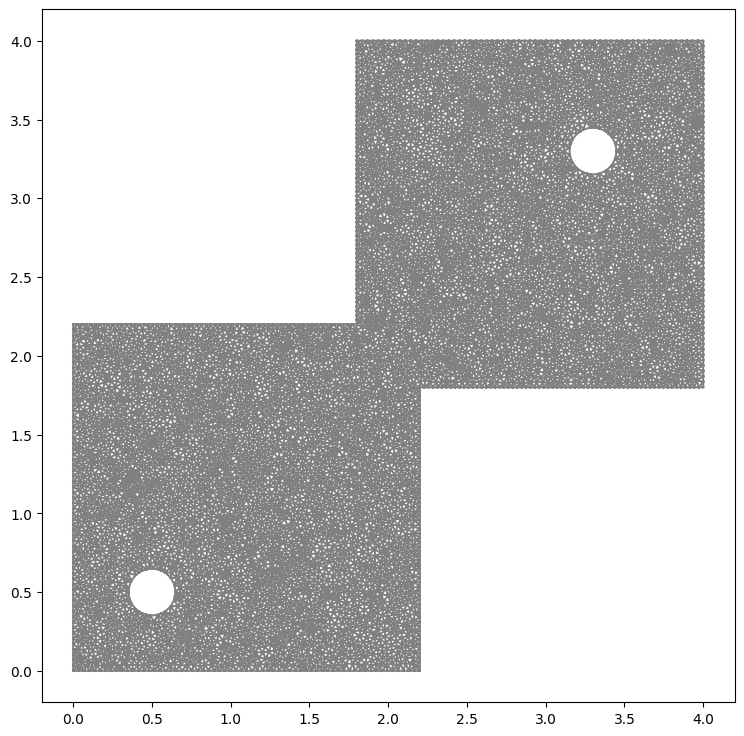

In [ ]:
# Defining the squares
square1  = Rectangle(Point(0.,0.),Point(2.2,2.2))
square2  = Rectangle(Point(1.8,1.8),Point(4.,4.))
# Defining the circles
circle_diam = 0.3
circle1 = Circle(Point(0.5,0.5), circle_diam/2.)
circle2 = Circle(Point(3.3,3.3), circle_diam/2.)

# Defining the domain
domain = square1+square2-circle1-circle2

# Denerate the mesh
mesh = generate_mesh(domain, 100)
plot(mesh)

print(mesh.num_cells())
print(mesh.num_vertices())

In [ ]:
V_element = FiniteElement('Lagrange', triangle, 1)
V = FunctionSpace(mesh, V_element)
u = TrialFunction(V)
u_sol = Function(V)
v = TestFunction(V)

f = Constant(0.)



### More complex BC!
For each of the boundaries I define a different Dirichlet BC with constant coefficients:
* 0 on bottom left square
* 2 on top right square
* 1 on both circles

In [ ]:
## Boundaries
bottom_left = 'near(x[0],0)'
right = 'near(x[0],2.2)'
bottom = 'near(x[1],0)'
top = 'near(x[1],0.41)'
cylinder_surf = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3'
# if it sees any DOF which is close to the boundary, it is inside the cylinder

bc_left = DirichletBC(V, 0., left)
bc_right = DirichletBC(V, 1., right)
bc_bottom = DirichletBC(V, 3., bottom)
bc_top = DirichletBC(V, -2., top)
bc_cylinder = DirichletBC(V, -1., cylinder_surf)

bcs = [bc_left, bc_right, bc_bottom, bc_top, bc_cylinder]

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_8a1899c41ab469ea970876b2052caff1f76ebd21

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_66]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0188258 seconds.

INFO:FFC:Compiler stage 2:

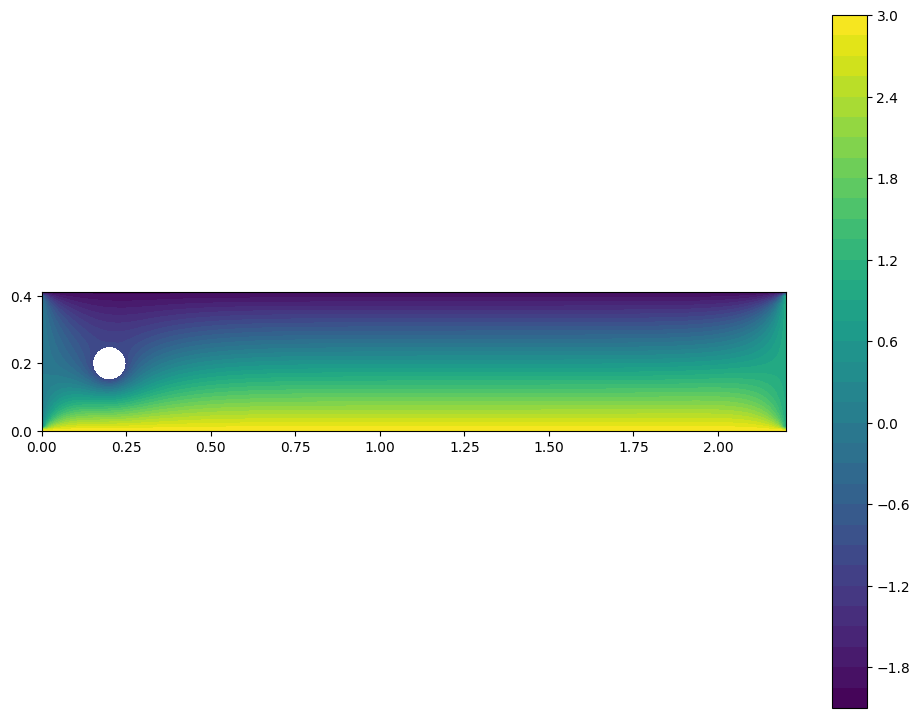

In [ ]:
# Write the weak form
lhs = inner(grad(u),grad(v))*dx
rhs = inner(f,v)*dx

# Assemble matrix
LHS = assemble(lhs)
RHS = assemble(rhs)

# Apply BC for all BCs in the list
for bc in bcs:
    bc.apply(LHS)
    bc.apply(RHS)

# Solve the liner problem
solve(LHS, u_sol.vector(), RHS)

# Plot the solution and add a colorbar
pp=plot(u_sol)
plt.colorbar(pp)

## Neumann on a piece of boundary

Suppose that on the previous test we want to set a Neumann BC on the top boundary. We can do this by integrating the weak form on the top boundary and setting the rhs to the value we are interested in:
$$
\Gamma_N = \{x \in \Gamma \, | \, y = 0.41 \text{ or }y=0\},\qquad \Gamma_D = \partial\Omega \setminus \Gamma_N\qquad V_h= \left\{v \in X^r_h(\Omega) \, | \, v=0 \text{ on } \Gamma_D\right\}
$$
Strong form
$$
\begin{cases}
    -\Delta u = f & \text{in } \Omega\\
    u = 0 & \text{on } \Gamma_D\\
    \frac{\partial u}{\partial n} = g & \text{on } \Gamma_N
\end{cases}
$$
Weak form
$$
\begin{align*}
    &-\int_{\Omega} \Delta u v \mathrm{d}x = \int_{\Omega} f v \mathrm{d}x\\
    &\int_{\Omega} \nabla u\cdot \nabla v \mathrm{d}x  - \int_{\Gamma_D} \nabla u \cdot n \underbrace{v}_{=0} \mathrm{d}s - \int_{\Gamma_N} \underbrace{\nabla u \cdot n}_{=g} v \mathrm{d}s = \int_{\Omega} f v \mathrm{d}x\\
    &\int_{\Omega} \nabla u\cdot \nabla v \mathrm{d}x   = \int_{\Omega} f v \mathrm{d}x + \int_{\Gamma_N} g v \mathrm{d}s
\end{align*}
$$

In [ ]:
## Boundaries
left = 'near(x[0],0)'
right = 'near(x[0],2.2)'
# bottom = 'near(x[1],0)'
cylinder_surf = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3'

bc_left = DirichletBC(V, 0., left)
bc_right = DirichletBC(V, 1., right)
# bc_bottom = DirichletBC(V, 3., bottom)
bc_cylinder = DirichletBC(V, -1., cylinder_surf)

bcs = [bc_left, bc_right,  bc_cylinder]

In [ ]:

# Setting the markers for the boundaries I'm interested in for neumann BCs
# A comment on the last argument: if a rectangle has dim=2, its edge will have dim=1.
boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)

# I set all markers to 0 in all boundaries
boundary_markers.set_all(0)

# Define the bottom boundary
top_boundary = AutoSubDomain(lambda x : near(x[1], 0.41, DOLFIN_EPS))

# Set its marker to 1
top_boundary.mark(boundary_markers, 1)

# Define the bottom boundary
bottom_boundary = AutoSubDomain(lambda x : near(x[1], 0.0, DOLFIN_EPS))

# Set its marker to 1
bottom_boundary.mark(boundary_markers, 2)

# Now I can redefine the border measure using these markers
ds = Measure("ds")(subdomain_data=boundary_markers)

# Then I can integrate only over the bottom boundary the functions that I want and assemble the RHS
g=Expression('sin(x[1])', degree=2)


In [ ]:
# Write the weak form
lhs = inner(grad(u),grad(v))*dx
rhs = g*v*ds(1)+g*v*ds(2)

# Assemble matrix
LHS = assemble(lhs)
RHS = assemble(rhs)

# Apply BC for all BCs in the list
for bc in bcs:
    bc.apply(LHS)
    bc.apply(RHS)

# Solve the liner problem
solve(LHS, u_sol.vector(), RHS)

# Plot the solution and add a colorbar
pp=plot(u_sol)
plt.colorbar(pp)

## Exercise
Test the order of accuracy also with Neumann boundary conditions using the exact solution we have seen above!